In [14]:
import sys
import warnings
from config import *

DATASET = "PF00397"
sys.path.append(f"{ROOT}")
device = "cpu"

warnings.filterwarnings("ignore")

In [15]:
import numpy as np
import pandas as pd
import time
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.data import SecondaryStructureRawDataset
from ss_inference.model import NetSurfP2
from ss_inference.utils import *

from config import DATA
from pgm.data import SequenceData
from pgm.layers import GaussianLayer, OneHotLayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.utils import *

from pattern_matching.loss import *
from pattern_matching.pattern import PatternMatching, Matching

torch.cuda.is_available()

True

## DCA Rejection Sampling

https://en.wikipedia.org/wiki/Rejection_sampling

### Independant model

Let's consider an independant model such that $E(x) = \sum_i g_i(x_i) = g(x)$. We want to extend it to include secondary structure QA. We consider $r$ a pattern a $R$ the set of secondary structure matching pattern $r$.
$$M(x) = \sum_{s \in R} \mathbb P(s|x)$$

Then $m(x) = - \log(M(x))$. We can then establish that $E(x) = g(x) + m(x)$. If we want to weight the two value we set $E$ to be $E(x) = g(x) + \frac{1}{T} m(x)$. We then have :

$$\mathbb{P}(x) = \frac{1}{Z} G(x)M(x)^{1/T}$$

How do we sample according to this probability ? Sampling with G(x) is easy but $M(x)$ is not invertible. We rely on rejection sampling.

To do this we sample following to the process :
- We sample $X$ according to $G(x)$ and $U$ according to a unifrom distrbituion in $[0,1]$
- if $M(X)^{1/T} < U$ we accept the sample, else we reject the sample and go back to step 1

We then have :
$$\mathbb{P}(X = x) \propto G(x)M(x)^{1/T}$$

## SS3 prediction

In [16]:
model_ss3 = NetSurfP2(50, "netsurfp2")
optimizer = optim.Adam(model_ss3.parameters(), lr=0.001)
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_50feats.h5"))
model_ss3.eval()
model_ss3 = model_ss3.to("cuda")

model_ss3

Model netsurfp2-50

## Data

In [17]:
dataset = SequenceData(f"{DATA}/{DATASET}", dataset="full")
loader = DataLoader(dataset, batch_size = 100, 
                          shuffle = True)
N, qv = dataset.raw_sequences.shape[1], dataset.raw_sequences.shape[2]

In [18]:
from torch.distributions.one_hot_categorical import OneHotCategorical

independant = np.zeros((dataset.raw_sequences.shape[1], dataset.raw_sequences.shape[2]))
for w, v in zip(dataset.weights,dataset.raw_sequences):
    independant += w*v
independant /= np.sum(dataset.weights)
independant = torch.FloatTensor(independant).to(device)

independant_sampler = OneHotCategorical(independant)

In [19]:
pots = np.zeros((dataset.raw_sequences.shape[1], dataset.raw_sequences.shape[2]))
for w, v in zip(dataset.weights,dataset.raw_sequences):
    pots += w*v
pots /= np.sum(dataset.weights)
pots = pots.T
pots = torch.FloatTensor((pots.T-np.mean(pots, 1)).T).reshape(-1).to(device)

## RBM

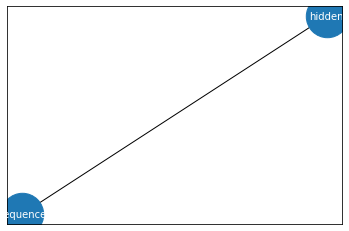

Iteration 0 : 0.004792404361069202
Iteration 200 : 3.2124345841875765
Iteration 400 : 12.83503515078337
Iteration 600 : 29.430040588515112
Iteration 800 : 54.27352224840433
Iteration 1000 : 89.42802830590517
Iteration 1200 : 140.5916180665663
Iteration 1400 : 216.40690044118674
Iteration 1600 : 313.16912106229574
Iteration 1800 : 427.01079908563406
Estimated Z : 15.385


15.385404586791992

In [20]:
visible_layers = ["sequence"]
hidden_layers = ["hidden"]

v = OneHotLayer(pots, N=N, q=qv, name="sequence")
h = GaussianLayer(N=200, name="hidden")

E = [(v.name, h.name)]

model1 = MRF(layers = {v.name: v,
                    h.name: h},
            edges = E,
            name = "")

for visible in visible_layers:
    edge = model1.get_edge(visible, "hidden")
    
model1.load(f"{DATA}/{DATASET}/weights/seq-reg-200_630.h5")
model1.ais(n_inter = 2000, verbose = True)

## Rejection Sampling

In [21]:
from random import random

def fillna(x, value = 0):
    idx = torch.where(x!=x)
    x[idx] = 0
    return x

def local_rejection_sampling(model, matcher, n_samples, T, visible_layers = None, hidden_layers = None):
    samples = []
    while(True):
        for batch_idx, data in enumerate(loader):
            print(f"{len(samples)}/{n_samples} [{int(100*len(samples)/n_samples)}%]", end="\r")
            if model == "natural":
                x = data[0].permute(0,2,1)
            elif model == "independant":
                x = independant_sampler.sample_n(200).permute(0,2,1)
            else:
                d_0 = {k: v.float().permute(0, 2, 1).to(device) for k, v in zip(LAYERS_NAME, data[:1]) if k in visible_layers}
                batch_size, q, N = d_0["sequence"].size()
                _, d_f = model.gibbs_sampling(d_0, visible_layers, hidden_layers, k=30)
                x = d_f["sequence"]
                
            m = matcher(Matching(x),30).detach().clamp(0,1)
            u = torch.arange(30).reshape(1,1,-1)
            #X = scaler.transform((m*u).sum(-1))
            #X_max = torch.tensor(np.max(np.abs(X), 1)/STD)
            
            X = (m*u).sum(-1)
            gm_scores = torch.zeros(*X.size())
            for k,gm in enumerate(gms):
                X_ = X[:,k:k+1]
                X_[:,0] = fillna(X_[:,0],0)
                gm_scores[:,k] = torch.tensor(gm.score_samples(X_))
            mx = gm_scores.min(-1).values.clamp(-15,0)
            #mx = torch.log(1-torch.pow(torch.erf(X_max/np.sqrt(2)),len_pat))
            for x_, mx_ in zip(x, mx):
                if len(samples) >= n_samples:
                    return samples
                thr = np.exp(mx_/T)
                if random() < thr:
                    samples.append((x_, -mx_))
    return samples

def rejection_sampling(model, matcher, n_samples, T, visible_layers = None, hidden_layers = None):
    samples = []
    while(True):
        for batch_idx, data in enumerate(loader):
            print(f"{len(samples)}/{n_samples} [{int(100*len(samples)/n_samples)}%]", end="\r")
            if model == "natural":
                x = data[0].permute(0,2,1)
            elif model == "independant":
                x = independant_sampler.sample_n(200).permute(0,2,1)
            else:
                d_0 = {k: v.float().permute(0, 2, 1).to(device) for k, v in zip(LAYERS_NAME, data[:1]) if k in visible_layers}
                batch_size, q, N = d_0["sequence"].size()
                _, d_f = model.gibbs_sampling(d_0, visible_layers, hidden_layers, k=30)
                x = d_f["sequence"]
            m = matcher(Matching(x))
            mx = (m.M/m.ls).detach()
            for x_, mx_ in zip(x, mx):
                if len(samples) >= n_samples:
                    return samples
                thr = np.exp(mx_/T)
                if random() < thr:
                    samples.append((x_, -mx_))

In [23]:
seq_hmm = torch.tensor(dataset[0][3]).t()[20:]
torch.save(seq_hmm, f"{DATA}/{DATASET}/hmm.pt")
_, size = seq_hmm.size()

n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/patterns.pkl","rb"))
regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) for i in x])
size = 150
Q = np.ones((3, size+1, size+1)) * (-np.inf)
e = size
for i in range(size+1):
    Q[:3, i, i+1:] = 0
Q = Q.reshape(1, *Q.shape)

ss_hmm = pickle.load(open(f"{DATA}/{DATASET}/ss_profile.pkl", "rb"))
seq_hmm = torch.load(f"{DATA}/{DATASET}/hmm.pt")

#matcher = PatternMatchingLoss(model_ss3, pattern = regexes[1], Q = Q ,
#                          seq_hmm = seq_hmm, ss_hmm = ss_hmm, 
#                          size = size, name = c_patterns[1])
matcher = LocalPatternMatchingLoss(model_ss3, pattern = regexes[0], Q = Q, 
                                   seq_hmm = seq_hmm, ss_hmm = ss_hmm, 
                                   size = size, name = c_patterns[0])

In [24]:
L_ = []
for batch_idx, data in tqdm(enumerate(loader)):
    x = data[0].permute(0,2,1)
    L = matcher(Matching(x), 30)
    L_.append(L.detach())
L_ = torch.cat(L_,0)

575it [06:45,  1.42it/s]


In [26]:
from sklearn.neighbors import KernelDensity

u = torch.arange(30).reshape(1,1,-1)
X = (L_*u).sum(-1)

gms = [KernelDensity(bandwidth=0.5, algorithm='auto', kernel='gaussian').fit(X[:,i:i+1]) for i in range(7)]

In [27]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from random import random

u = torch.arange(15).reshape(1,1,15)
X = (L_*u).sum(-1)

scaler = RobustScaler()
scaler.fit(X)
X_n = scaler.transform(X)

STD = 1/(2**0.5*torch.erfinv(torch.tensor(0.5))).item()
X_max = torch.tensor(np.max(np.abs(X_n), 1)/STD)

len_pat = X_n.shape[-1]
print(f"std = {STD:.4f} || len pattern = {len_pat}")

RuntimeError: The size of tensor a (30) must match the size of tensor b (15) at non-singleton dimension 2

In [ ]:
all_samples_hist = []
all_samples = []
Ts = [0.2]
for T in Ts:
    start = time.time()
    samples = local_rejection_sampling(model1, matcher, 2000, T, visible_layers, hidden_layers)
    all_samples_hist.append([x[1] for x in samples])
    all_samples.append([x[0] for x in samples])
    print(f"T = {T} || Samples/seconds : {int(2000/(time.time()-start))}")

In [ ]:
all_samples = [torch.cat([s_.view(1, *s_.size()) for s_ in s],0) for s in all_samples]
for T, s in zip(Ts, all_samples):
    torch.save(s, f"{DATA}/{DATASET}/gen_data/rbm_local_rejection_sampling_T_{T}.pt")
    #torch.save(s, f"{DATA}/{DATASET}/gen_data/ind_local_rejection_sampling_T_{T}.pt")
    #torch.save(s, f"{DATA}/{DATASET}/gen_data/natural.pt")